In [1]:
# Data Manipulation Libraries
import pandas as pd
import numpy as np
import pickle 
import datetime
from itertools import combinations
from pyjarowinkler import distance
import re

# NLP Libraries
from nltk.corpus import wordnet as wn
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Data Visualisation Libraries
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import HTML
from folium.plugins import MarkerCluster
from folium import plugins

# Geographical Data Libraries
import geopandas as gpd
import folium
import pgeocode
import shapefile
from json import dumps
from folium import FeatureGroup

import warnings
warnings.filterwarnings("ignore")

In [2]:
#__________________ Reading the data __________________#
with open('./data/MapData/ethnicity_df.pickle', 'rb') as fp:
    ethnicity_df = pickle.load(fp)

with open('./data/MapData/geoid_normalising.pickle', 'rb') as fp:
    geoid_normalising = pickle.load(fp)
    
with open('./data/MapData/chicago_inspections.pickle', 'rb') as fp:
    chicago_inspections = pickle.load(fp)
    
with open('./data/businessesChicago.pkl', 'rb') as fp:
    businesses = pickle.load(fp)
    
tract = pd.read_excel('./data/ZIP_TRACT_122017.xlsx')
    
zipcode_path = './data/zipCodesBoundaries.geojson'

In [71]:
#__________________ Migrating the ethnicity dataset towards a zipcode structure __________________#

majority_ethnicity = ethnicity_df[ethnicity_df['lntitle'] != 'Total']
majority_ethnicity = majority_ethnicity[majority_ethnicity['lntitle'] != 'Not Hispanic or Latino']
majority_ethnicity['geoid_match'] = majority_ethnicity['geoid_match'].astype(np.int64)

chicago_inspections["majority_ethnicity"] = np.zeros(len(chicago_inspections)) 
nanCounters = 0
for i in range(len(chicago_inspections)):
    try:
        zipp = chicago_inspections.iloc[i]["zip"] # Get zip of that instance
        tract_linked = tract[tract['zip'] == int(zipp)] # Get all tract numbers linked to the zip
        tract_linked = tract_linked['tract'].unique()
        temp = majority_ethnicity[majority_ethnicity['geoid_match'].isin(tract_linked)] # retrieve all the statistics linked to those tracks
        temp = temp.groupby('lntitle').sum().reset_index()
        majority = temp.iloc[np.argmax(temp["CIT_EST"])]['lntitle']
        chicago_inspections["majority_ethnicity"].iloc[i] = majority
    except ValueError:
        nanCounters += 1
        print(nanCounters)
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [3]:
with open('./data/chicago_inspections_ethnicity.pickle', 'rb') as fp:
    chicago_inspections = pickle.load(fp)

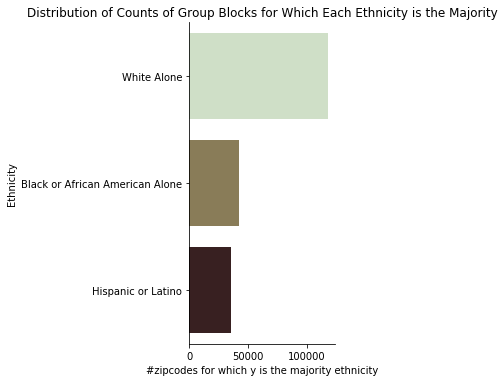

In [4]:
# __________________ Plotting the percentage of zipcodes dominated by each of the ethnicities __________________#
zip_ethnicity = chicago_inspections[chicago_inspections["majority_ethnicity"] != 0]
sns.catplot(y="majority_ethnicity", kind="count", palette="ch:.75", data=zip_ethnicity)
plt.ylabel("Ethnicity")
plt.xlabel("#zipcodes for which y is the majority ethnicity")
plt.title("Distribution of Counts of Group Blocks for Which Each Ethnicity is the Majority")
plt.show()

In [8]:
#__________________ Mapping Zip-Ethnicity __________________#
zip_eth = chicago_inspections[chicago_inspections["majority_ethnicity"] != 0]
zip_ethnicity = {}
for zipcode in zip_eth['zip'].unique():
    zippi = str(int(zipcode))
    temp = zip_eth[zip_eth['zip'] == zipcode]
    zip_ethnicity[zippi] = temp['majority_ethnicity'].iloc[0]
zip_ethnicity = pd.DataFrame(zip_ethnicity, index=[0]).transpose().reset_index()
zip_ethnicity.columns = ['zip', 'ethnicity']

In [4]:
chicago_inspections = chicago_inspections.fillna(0)
chicago_inspections = chicago_inspections[chicago_inspections['zip'] != 0]

In [138]:
#---------------- Getting all restaurants ----------------#
## Waiting for Alfonso to get the google revs in place
chicago_inspections.head(1)



,inspection_id,dba_name,aka_name,license,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,new_facility_type,new_violations
0,2320977,todd appel bar and cocktail,todd appel bar and cocktail,2589615.0,grocery store,Risk 2 (Medium),5868 N LINCOLN AVE,chicago,IL,60659.0,2019-11-01T00:00:00.000,canvas,No Entry,NaN,41.98806,-87.703704,"{'latitude': '-87.70370445181302', 'longitude'...",grocery store,[]


In [11]:
# Base Map
chicago_map = folium.Map(location=[41.806167, -87.7], zoom_start=10)
# Zipcode geometry
zipGeom = gpd.read_file("./data/zipCodesBoundaries.geojson")
zipGeom['zip'] = zipGeom['zip'].astype(int)
zipGeom['shape_area'] = zipGeom['shape_area'].astype(float)
chicago_inspections["zip"] = chicago_inspections['zip'].astype(int).astype(str)

# Plotting the white population
whites = list(zip_ethnicity[zip_ethnicity['ethnicity'] == 'White Alone']['zip'])
whites = zipGeom[zipGeom['zip'].isin(whites)]
folium.GeoJson(
    whites.to_json(),
    style_function=lambda feature: {
        'fillColor': "lightskyblue",
        'color': 'lightskyblue',
        'fillOpacity':0.7
    },
    name='White Population',
).add_to(chicago_map)

# Plotting the white population
baaa = list(zip_ethnicity[zip_ethnicity['ethnicity'] == 'Black or African American Alone']['zip'])
baaa = zipGeom[zipGeom['zip'].isin(baaa)]
folium.GeoJson(
    baaa.to_json(),
    style_function=lambda feature: {
        'fillColor': "dodgerblue",
        'color': 'dodgerblue',
        'opacity':0.7,
        'fillOpacity':0.7
    },
    name='Black or African American Population',
).add_to(chicago_map)

# Plotting the white population
hol = list(zip_ethnicity[zip_ethnicity['ethnicity'] == 'Hispanic or Latino']['zip'])
hol = zipGeom[zipGeom['zip'].isin(hol)]
folium.GeoJson(
    hol.to_json(),
    style_function=lambda feature: {
        'fillColor': "lightgreen",
        'color': 'lightgreen',
        'opacity':0.7,
        'fillOpacity':0.7
    },
    name='Hispanic or Latino',
).add_to(chicago_map)



# Inspected Restaurants
usZipLL = pd.read_csv('./data/uszipcodelatlong.csv')
chicago_inspections["zip"] = chicago_inspections['zip'].astype(int)
zipGeom = gpd.read_file("./data/zipCodesBoundaries.geojson")
zipGeom['zip'] = zipGeom['zip'].astype(int)
zipGeom['shape_area'] = zipGeom['shape_area'].astype(float)
bubbles = chicago_inspections.groupby('zip').nunique()[['license']].reset_index()

# Plotting
fg = FeatureGroup(name='#Restaurants').add_to(chicago_map)
#restaurants = plugins.FeatureGroupSubGroup(fg, 'Restaurants')
for i in range(0, len(bubbles)):
    try:
        zipcode = bubbles.iloc[i]['zip']
        zipinfo = usZipLL[usZipLL['ZIP'] == zipcode]
        area = zipGeom[zipGeom['zip'] == zipcode]['shape_area']
        if len(area) == 0:
            continue
        area = area * 10 / np.mean(zipGeom['shape_area'])
        area = area.values[0]
        location = [zipinfo['LAT'], zipinfo['LNG']]
        name = str(bubbles.iloc[i]['zip'])
        folium.Circle(
                    location=location,
                    popup=name,
                    name='restaurant',
                    radius = bubbles.iloc[i]['license']/area,
                    color='black',
                    fill=True,
                    fill_color='black',
                    tooltip = str(bubbles.iloc[i]['license']) + ' restaurants'
                ).add_to(fg)
    except TypeError:
        print(zipcode)
    except ValueError:
        print(zipcode)
        
        
#chicago_map.add_child(restaurants)  
    
folium.LayerControl().add_to(chicago_map)

chicago_map.save('./maps/DistributionEthnicityRestaurants.html')

60666


In [10]:
chicago_map